# Problem definition

SEC filings are long, filled with boilerplate language, and often difficult to parse through even as an experienced analyst. Let's assume that I have the following question:

> "What was the annual revenue for TSLA in 2024, and what was media sentiment after the SEC 10-K filings were released?"

For the sake of simplicity, let's assume the answer can be obtained with the following two sources:
- [TSLA 2024 10-K SEC filing](https://www.sec.gov/Archives/edgar/data/1318605/000162828025003063/tsla-20241231.htm#ie9fbbc0a99a6483f9fc1594c1ef72807_157), 347,000 tokens
- [Yahoo Finance article](https://finance.yahoo.com/news/tesla-inc-tsla-q4-2024-072241602.html), 5,000 tokens

To implement an architecture that could answer these questions, we have the following options. There are lots of LLM's we could use, but let's assume that we're using GPT 4o at commercial API usage rates. 

- GPT-4o with unfiltered context: Manually upload full context to GPT API. 
- GPT-4o with web search: Ask the question directly, and don't provide context.
- GPT-4o with keyword search: BM25 search to fetch top-N chunks that match query terms to article metadata, and send those chunks to the API.
- RAG with semantic search (GPT-4o): Search vector database for context, and  upload to GPT-4o

Using our article baseline, and assuming that each method can accurately answer the question, here are the daily cost extrapolations for a platform with the following levels of activity:

- We have a platform with 1000 concurrent users at any given moment
- These users use the platform for 10 hours per day
- Each user asks 1 question every 3 minutes, each similar to the above question (39 tokens).

| Scenario                           | Input Tokens | Output Tokens | Cost per Query (USD) | Total Daily Cost (USD) |
|------------------------------------|--------------|----------------|-----------------------|-------------------------|
| GPT-4o with unfiltered context     | 347,000      | 200            | $1.7390               | $347,800.00             |
| GPT-4o with web search             | 7,500        | 200            | $0.0415               | $8,300.00               |
| Keyword search + GPT-4o            | 3,000        | 200            | $0.0190               | $3,800.00               |
| RAG with semantic search (GPT-4o)  | 2,000        | 200            | $0.0140               | $2,800.00               |
| RAG with semantic search (GPT 3.5) | 2,000        | 200            | $0.0013               | $260              |

Our API costs would be 66% cheaper using a RAG compared to web search. If we optimize the semantic retrieval methodology for accuracy and use GPT 3.5 instead of 4o, it would be 97% cheaper. 

| Scenario                           | High Accuracy | Cost Efficient | Low Latency | Scalable | Curated Sources |
|------------------------------------|----------------|----------------|-------------|----------|---------------------|
| GPT-4o with unfiltered context     | ✅             | ❌             | ❌          | ❌       | ✅                  |
| GPT-4o with web search             | ✅             | ✅             | ✅          | ✅       | ❌                  |
| Keyword search + GPT-4o            | ❌             | ✅             | ✅          | ✅       | ✅                  |
| RAG with semantic search (GPT-4o)  | ✅             | ✅             | ✅          | ✅       | ✅                  |
| RAG with semantic search (GPT-3.5) | ✅             | ✅             | ✅          | ✅       | ✅                  |

# Evaluation Criteria

We'll implement all four scenarios above, and evaluate them on the following criteria:

- Tier 1: Single-source QA accuracy. *How well does our engine answer questions about the 10-K filings?*
    - Evaluation data set: [financial-qa-10k](https://huggingface.co/datasets/virattt/financial-qa-10K)
    - Evaluation metrics:
        - ROUGE
        - Recall@k for chunk retrieval
<!-- - Tier 2 (if time permits): Multi-source QA accuracy. *How well does our engine answer questions about the 10-K filings AND related media?*
    
    - Evaluation metrics:
        -  -->

# Datasets to use:

<!-- - **SEC 10-k filings** for the years 2020-2023 for AAPL, NVDA, TSLA, GOOGL. We'll scrape this data with the [EDGAR-CRAWLER](https://github.com/lefterisloukas/edgar-crawler) project. -->
- **Source SEC Filings**: the [financial-reports-sec](https://huggingface.co/datasets/JanosAudran/financial-reports-sec) dataset is already cleaned and separated into sections. I'll use this for simplicity; a real-life scenario would include implementing a pipeline to generate the features. 
- **Evaluation set**: QA answer responses based on the [financial-qa-10k](https://huggingface.co/datasets/virattt/financial-qa-10K) labeled dataset from HuggingFace. 


# How to implement

1. Download both the SEC docs and the evaluation set
2. 

# EDA

## SEC 10-K Filings

First we'll get the structured 10K filings

In [11]:
#imports 
%load_ext autoreload
%autoreload 2
import sys, os
from pathlib import Path

# Add project root to sys.path
project_root = Path.cwd().parent
sys.path.append(str(project_root))

sys.path.append("..")
import numpy as np
import pandas as pd
from pprint import pprint


In [36]:
from datasets import load_dataset

# ds = load_dataset("JanosAudran/financial-reports-sec", "large_full")
# ds = load_dataset("JanosAudran/financial-reports-sec", "large_full")

# Save to parquet
# ds.save_to_disk("data/df_filings_full.parquet")
import duckdb

# Connect to in-memory database
con = duckdb.connect(database=':memory:')


query = """
SELECT 
  sentence, 
  docID, 
  CAST(RIGHT(docID, 4) AS INTEGER) AS fiscal_year,
  tickers[1] AS ticker,
  sentenceID
FROM read_parquet('../data/df_filings_full.parquet')
WHERE tickers IS NOT NULL
  AND array_length(tickers) > 0
  AND tickers[1] IN ('AAPL', 'META', 'TSLA', 'NVDA')
  AND LEN(sentence) > 20


"""
# Read parquet file and display first 10 rows
df = con.execute(query).df()
display(df)


,sentence,docID,fiscal_year,ticker,sentenceID
0,"ITEM 1. BUSINESS Overview We design, develop, ...",0001318605_10-K_2020,2020,TSLA,0001318605_10-K_2020_section_1_0
1,We generally sell our products directly to cus...,0001318605_10-K_2020,2020,TSLA,0001318605_10-K_2020_section_1_1
2,We also continue to grow our customer-facing i...,0001318605_10-K_2020,2020,TSLA,0001318605_10-K_2020_section_1_2
3,"We emphasize performance, attractive styling a...",0001318605_10-K_2020,2020,TSLA,0001318605_10-K_2020_section_1_3
4,We also strive to lower the cost of ownership ...,0001318605_10-K_2020,2020,TSLA,0001318605_10-K_2020_section_1_4
...,...,...,...,...,...
98343,Exhibits See the Exhibit Index immediately fol...,0001326801_10-K_2012,2012,META,0001326801_10-K_2012_section_15_6
98344,POWER OF ATTORNEY KNOW ALL PERSONS BY THESE PR...,0001326801_10-K_2012,2012,META,0001326801_10-K_2012_section_15_7
98345,Pursuant to the requirements of the Securities...,0001326801_10-K_2012,2012,META,0001326801_10-K_2012_section_15_8
98346,† Portions of exhibit have been granted confid...,0001326801_10-K_2012,2012,META,0001326801_10-K_2012_section_15_9


The data we have above is at the sentence level. 

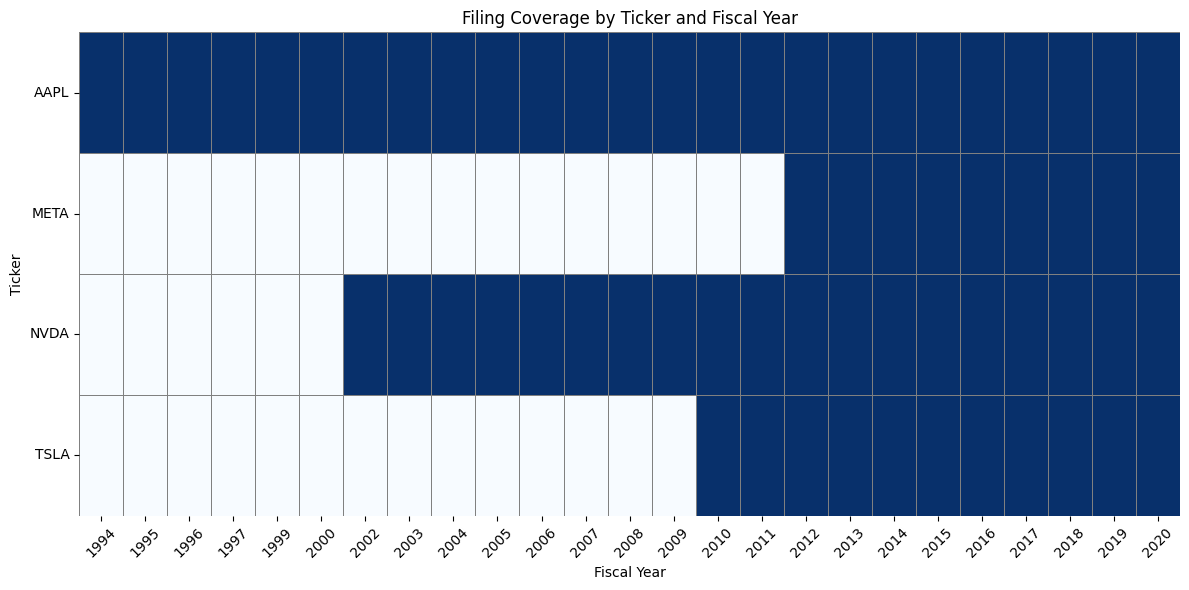

In [37]:
from eda.viz import plot_filing_coverage

plot_filing_coverage(df)

Looks like we only have all companies from 2012-2020, so we'll restrict our analysis to these years

In [38]:
df = df[df['fiscal_year'].between(2012, 2019)]

Let's see if there are vastly different distributions in the number of tokens per ticker per year. 

## Chunking

Let's see if we can determine the optimal chunking strategy. First we'll see how many tokens we have per document, per sentence, and per section. 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


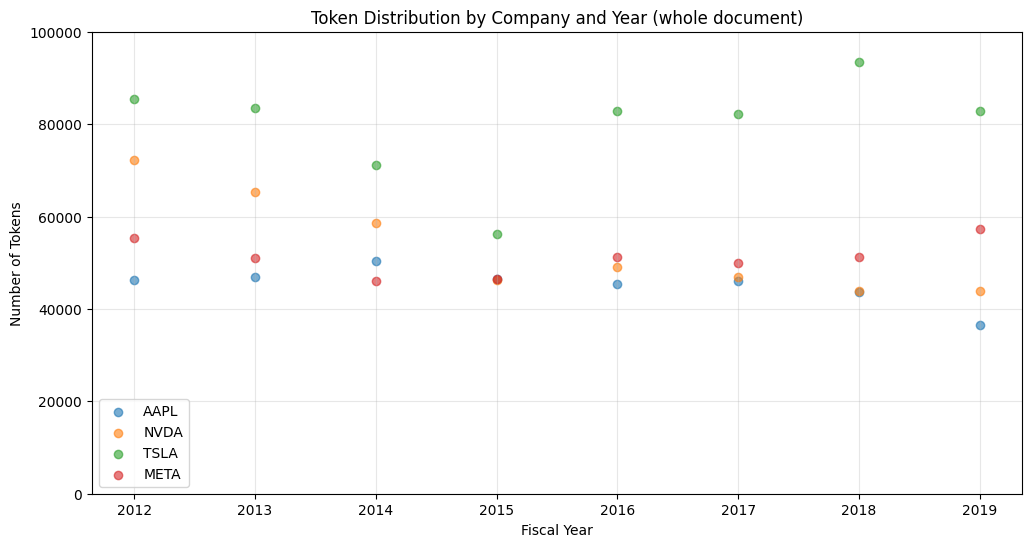

,docID,ticker,fiscal_year,full_text,num_tokens
0,0000320193_10-K_2012,AAPL,2012,Item 1. Business Company Background The Compan...,46187
1,0000320193_10-K_2013,AAPL,2013,Item 1. Business Company Background The Compan...,46989
2,0000320193_10-K_2014,AAPL,2014,Item 1. Business Company Background The Compan...,50371
3,0000320193_10-K_2015,AAPL,2015,Item 1. Business Company Background The Compan...,46542
4,0000320193_10-K_2016,AAPL,2016,Item 1. Business Company Background The Compan...,45378


In [62]:
import matplotlib.pyplot as plt
from eda.viz import count_tokens
%load_ext autoreload
%autoreload 2

# Group by docID to get full document text
df_docs = (df.sort_values(['docID', 'sentence_num'])
          .groupby(['docID', 'ticker', 'fiscal_year'])
          .agg({'sentence': ' '.join})
          .reset_index()
          .rename(columns={'sentence': 'full_text'}))

# Count tokens in full text
df_docs['num_tokens'] = df_docs['full_text'].apply(count_tokens)

# Create scatter plot
plt.figure(figsize=(12, 6))
for ticker in df_docs['ticker'].unique():
    ticker_data = df_docs[df_docs['ticker'] == ticker]
    plt.scatter(ticker_data['fiscal_year'], 
                ticker_data['num_tokens'],
                label=ticker,
                alpha=0.6)

plt.title('Token Distribution by Company and Year (whole document)')
plt.xlabel('Fiscal Year')
plt.ylabel('Number of Tokens')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 100_000)
plt.show()

df_docs.head()

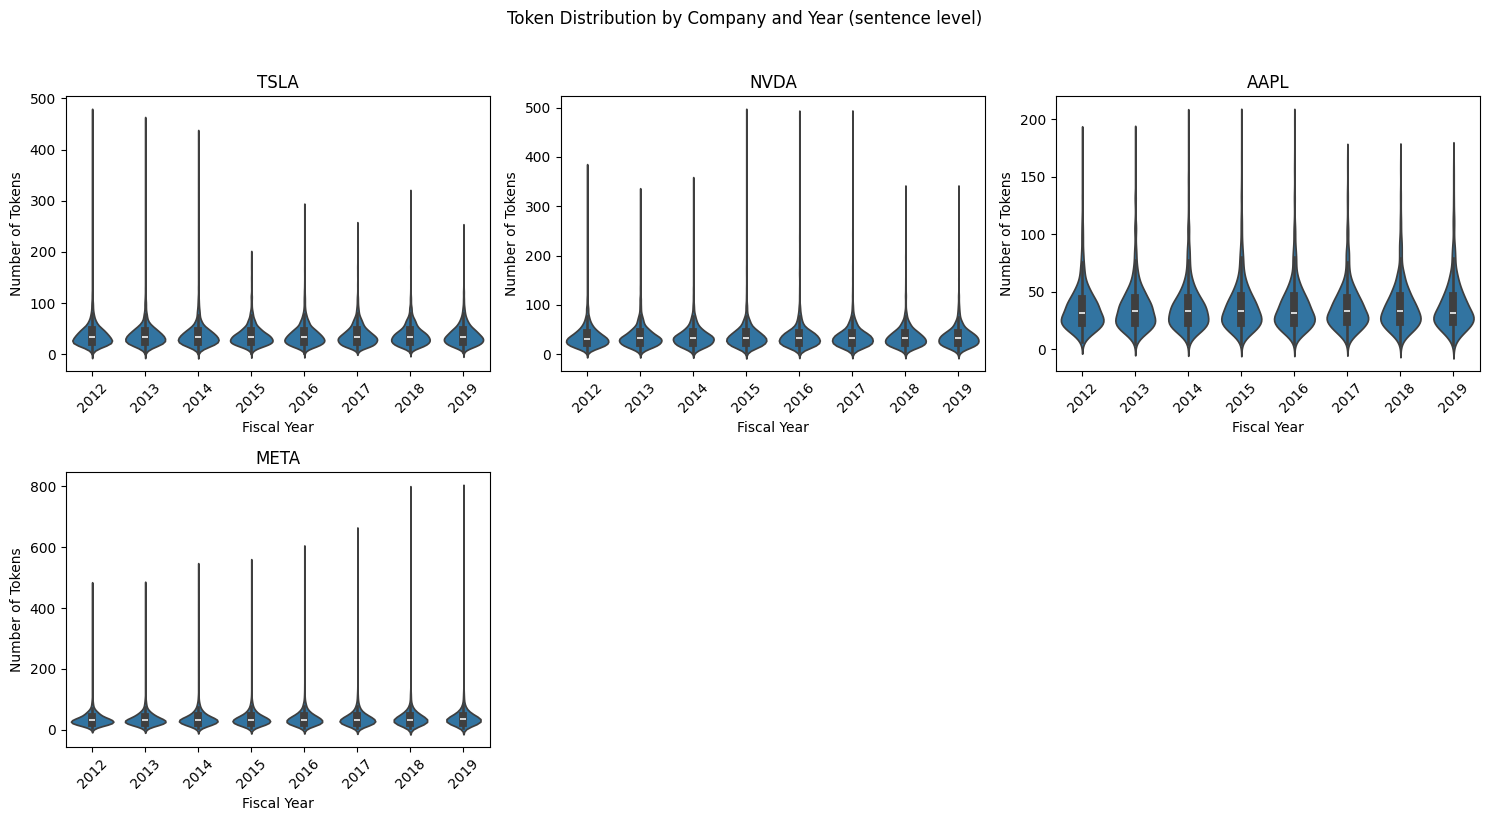

,sentence,docID,fiscal_year,ticker,sentenceID,section_num,section_letter,section,sentence_num,num_tokens
2120,"ITEM 1. BUSINESS Overview We design, develop, ...",0001318605_10-K_2019,2019,TSLA,0001318605_10-K_2019_section_1_0,1,,1,0,36
2121,We are the world’s first vertically integrated...,0001318605_10-K_2019,2019,TSLA,0001318605_10-K_2019_section_1_1,1,,1,1,27
2122,We generally sell our products directly to cus...,0001318605_10-K_2019,2019,TSLA,0001318605_10-K_2019_section_1_2,1,,1,2,17
2123,We also continue to grow our customer-facing i...,0001318605_10-K_2019,2019,TSLA,0001318605_10-K_2019_section_1_3,1,,1,3,40
2124,"We emphasize performance, attractive styling a...",0001318605_10-K_2019,2019,TSLA,0001318605_10-K_2019_section_1_4,1,,1,4,36


In [55]:
df['num_tokens'] = df['sentence'].apply(count_tokens)
plot_token_distribution(df, title='Token Distribution by Company and Year (sentence level)')
df.head()

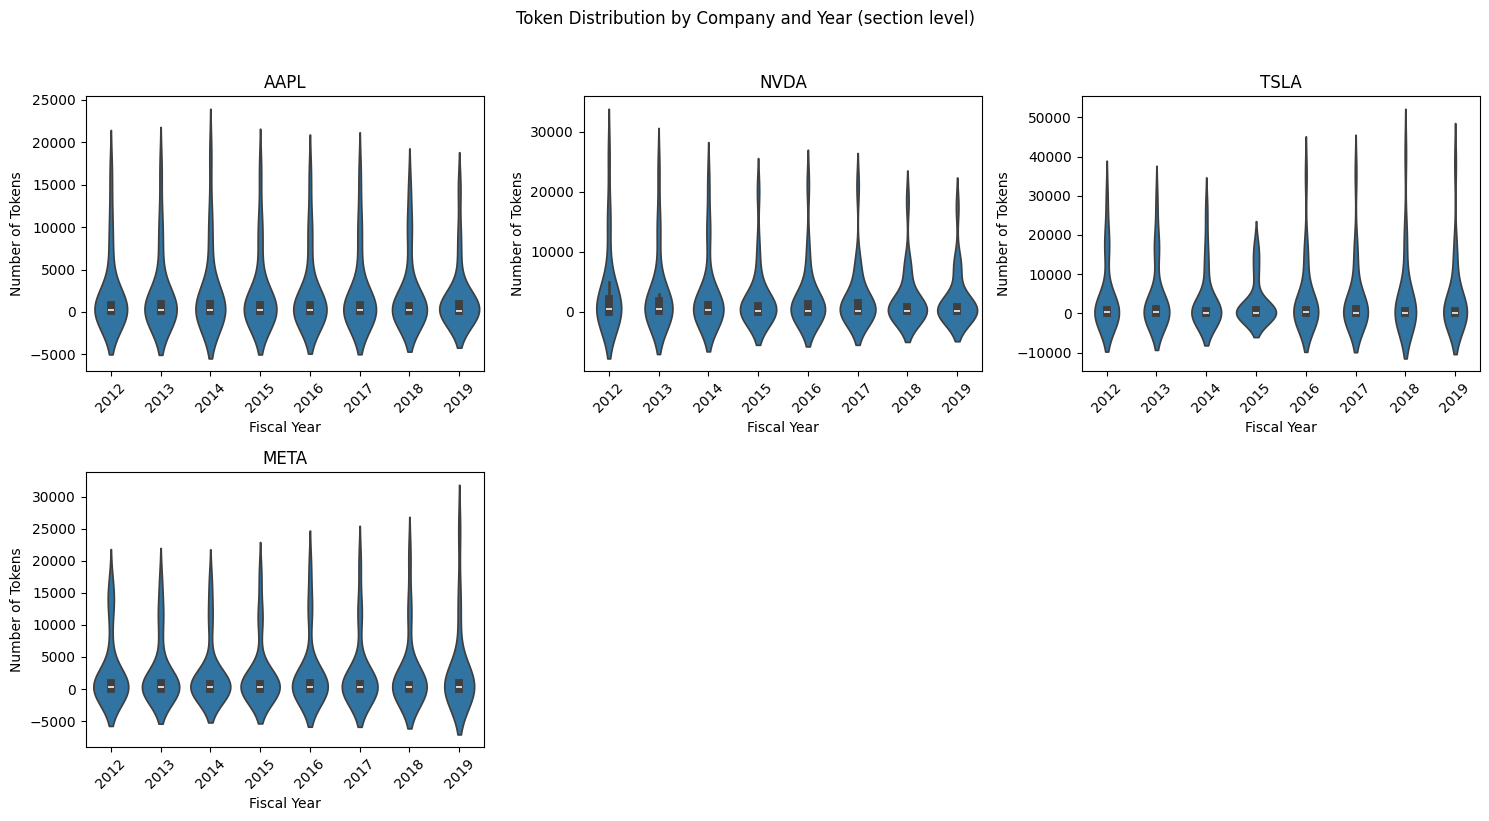

In [58]:
# Group by docID and section_num, sort by sentence_num, and concatenate sentences
df_docs = (df.sort_values(['docID', 'section_num', 'section_letter', 'sentence_num'])
          .groupby(['docID', 'ticker', 'fiscal_year', 'section_num', 'section_letter'])
          .agg({'sentence': ' '.join})
          .reset_index()
          .rename(columns={'sentence': 'full_text'}))

# Count tokens in full text
df_docs['num_tokens'] = df_docs['full_text'].apply(count_tokens)

plot_token_distribution(df_docs, title='Token Distribution by Company and Year (section level)')


OK so we have some very long sections. Most are between 0-5k tokens with a long tail up to 50k. So, we're going to have to do some pretty significant chunking. 

Documents are between 50-100k tokens. 

Sentences are usually under 100. 

- Target chunk size: 350 tokens. This is pretty standard and should get us a couple of sentences to work with, and if RAG retrieval is good then we might only need that much.
- Overlap: 50 tokens
- Hard ceiling: 800, it seems like there aren't any higher than that. 

In [65]:
df.columns

Index(['sentence', 'docID', 'fiscal_year', 'ticker', 'sentenceID',
       'section_num', 'section_letter', 'section', 'sentence_num',
       'num_tokens'],
      dtype='object')

In [ ]:
from rag.chunkers import SmartChunker

chunker = SmartChunker(target_tokens=350, hard_ceiling=800, overlap_tokens=50)

chunks = chunker.run(df)
chunks

ValueError: Input DataFrame is missing required columns for chunking.

## Parameter optimization

First we should optimize the number of tokens per chunk split. 

In [15]:
%load_ext autoreload
%autoreload 2

import sys, os
from pathlib import Path
sys.path.append(str(Path(os.getcwd()).parent))
import pandas as pd

from chunking_comparison import compare_chunking_configs

configs = [
    {"target_tokens": 150, "overlap_tokens": 25, "name": "Small_150_25"},
    {"target_tokens": 300, "overlap_tokens": 50, "name": "Medium_300_50"},
    {"target_tokens": 500, "overlap_tokens": 100, "name": "Large_500_100"},
    {"target_tokens": 750, "overlap_tokens": 150, "name": "XLarge_750_150"}
]

# compare_chunking_configs(num_questions=50, configs=configs)
df_results = pd.read_csv('../data/chunking_comparison_results.csv')
df_results

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,Unnamed: 0,configuration,target_tokens,overlap_tokens,total_chunks,recall_at_1,recall_at_3,recall_at_5,recall_at_10,mrr,rouge1_f,rouge2_f,rougeL_f
0,3,XLarge_750_150,750,150,9024,0.516129,0.580645,0.612903,0.645161,0.554071,0.345143,0.245680,0.301819
1,2,Large_500_100,500,100,13633,0.395833,0.458333,0.500000,0.500000,0.436458,0.356420,0.252100,0.314041
2,1,Medium_300_50,300,50,23139,0.354167,0.479167,0.500000,0.583333,0.425198,0.428278,0.314343,0.382268
3,0,Small_150_25,150,25,57849,0.239130,0.456522,0.521739,0.586957,0.363095,0.421386,0.290112,0.365680


Takeaways:
 - Recall at 1 is highest with the extra large model. This makes sense, as the more context we feed the model, the more likely the correct information is in the chunk. 
 - MRR (Mean Reciprocal Rank) is also highest in the extra large model. This also makes sense, as more context per chunk leads to a higher probability that the correct information is in the chunk. 
- Rouge-1 is highest for smaller models. When we have smaller chunks, we have a lower probability of getting the most accurate chunk, but when we do the unigram overlap is high. 

This tells me that we should keep a higher chunk size. We have could more overlap AND more chunks, but for the sake of this exercise I'm going to assume that 750/150 is the optimal combination for now. 

In [ ]:
%load_ext autoreload
%autoreload 2

import sys, os
from pathlib import Path
sys.path.append(str(Path(os.getcwd()).parent))
import pandas as pd

from chunking_comparison import compare_chunking_configs

configs = [
    {"target_tokens": 150, "overlap_tokens": 25, "name": "Small_150_25"},
    {"target_tokens": 300, "overlap_tokens": 50, "name": "Medium_300_50"},
    {"target_tokens": 500, "overlap_tokens": 100, "name": "Large_500_100"},
    {"target_tokens": 750, "overlap_tokens": 150, "name": "XLarge_750_150"}
]

# compare_chunking_configs(num_questions=50, configs=configs)
df_results = pd.read_csv('../data/chunking_comparison_results.csv')
df_results

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,Unnamed: 0,configuration,target_tokens,overlap_tokens,total_chunks,recall_at_1,recall_at_3,recall_at_5,recall_at_10,mrr,rouge1_f,rouge2_f,rougeL_f
0,3,XLarge_750_150,750,150,9024,0.516129,0.580645,0.612903,0.645161,0.554071,0.345143,0.245680,0.301819
1,2,Large_500_100,500,100,13633,0.395833,0.458333,0.500000,0.500000,0.436458,0.356420,0.252100,0.314041
2,1,Medium_300_50,300,50,23139,0.354167,0.479167,0.500000,0.583333,0.425198,0.428278,0.314343,0.382268
3,0,Small_150_25,150,25,57849,0.239130,0.456522,0.521739,0.586957,0.363095,0.421386,0.290112,0.365680


In [ ]:
%load_ext autoreload
%autoreload 2

import sys, os
from pathlib import Path
sys.path.append(str(Path(os.getcwd()).parent))
import pandas as pd

from chunking_comparison import compare_chunking_configs

configs = [
    {"target_tokens": 150, "overlap_tokens": 25, "name": "Small_150_25"},
    {"target_tokens": 300, "overlap_tokens": 50, "name": "Medium_300_50"},
    {"target_tokens": 500, "overlap_tokens": 100, "name": "Large_500_100"},
    {"target_tokens": 750, "overlap_tokens": 150, "name": "XLarge_750_150"}
]

# compare_chunking_configs(num_questions=50, configs=configs)
df_results = pd.read_csv('../data/chunking_comparison_results.csv')
df_results

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,Unnamed: 0,configuration,target_tokens,overlap_tokens,total_chunks,recall_at_1,recall_at_3,recall_at_5,recall_at_10,mrr,rouge1_f,rouge2_f,rougeL_f
0,3,XLarge_750_150,750,150,9024,0.516129,0.580645,0.612903,0.645161,0.554071,0.345143,0.245680,0.301819
1,2,Large_500_100,500,100,13633,0.395833,0.458333,0.500000,0.500000,0.436458,0.356420,0.252100,0.314041
2,1,Medium_300_50,300,50,23139,0.354167,0.479167,0.500000,0.583333,0.425198,0.428278,0.314343,0.382268
3,0,Small_150_25,150,25,57849,0.239130,0.456522,0.521739,0.586957,0.363095,0.421386,0.290112,0.365680


In [ ]:
%load_ext autoreload
%autoreload 2

import sys, os
from pathlib import Path
sys.path.append(str(Path(os.getcwd()).parent))
import pandas as pd

from chunking_comparison import compare_chunking_configs

configs = [
    {"target_tokens": 150, "overlap_tokens": 25, "name": "Small_150_25"},
    {"target_tokens": 300, "overlap_tokens": 50, "name": "Medium_300_50"},
    {"target_tokens": 500, "overlap_tokens": 100, "name": "Large_500_100"},
    {"target_tokens": 750, "overlap_tokens": 150, "name": "XLarge_750_150"}
]

# compare_chunking_configs(num_questions=50, configs=configs)
df_results = pd.read_csv('../data/chunking_comparison_results.csv')
df_results

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,Unnamed: 0,configuration,target_tokens,overlap_tokens,total_chunks,recall_at_1,recall_at_3,recall_at_5,recall_at_10,mrr,rouge1_f,rouge2_f,rougeL_f
0,3,XLarge_750_150,750,150,9024,0.516129,0.580645,0.612903,0.645161,0.554071,0.345143,0.245680,0.301819
1,2,Large_500_100,500,100,13633,0.395833,0.458333,0.500000,0.500000,0.436458,0.356420,0.252100,0.314041
2,1,Medium_300_50,300,50,23139,0.354167,0.479167,0.500000,0.583333,0.425198,0.428278,0.314343,0.382268
3,0,Small_150_25,150,25,57849,0.239130,0.456522,0.521739,0.586957,0.363095,0.421386,0.290112,0.365680


In [ ]:
%load_ext autoreload
%autoreload 2

import sys, os
from pathlib import Path
sys.path.append(str(Path(os.getcwd()).parent))
import pandas as pd

from chunking_comparison import compare_chunking_configs

configs = [
    {"target_tokens": 150, "overlap_tokens": 25, "name": "Small_150_25"},
    {"target_tokens": 300, "overlap_tokens": 50, "name": "Medium_300_50"},
    {"target_tokens": 500, "overlap_tokens": 100, "name": "Large_500_100"},
    {"target_tokens": 750, "overlap_tokens": 150, "name": "XLarge_750_150"}
]

# compare_chunking_configs(num_questions=50, configs=configs)
df_results = pd.read_csv('../data/chunking_comparison_results.csv')
df_results

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,Unnamed: 0,configuration,target_tokens,overlap_tokens,total_chunks,recall_at_1,recall_at_3,recall_at_5,recall_at_10,mrr,rouge1_f,rouge2_f,rougeL_f
0,3,XLarge_750_150,750,150,9024,0.516129,0.580645,0.612903,0.645161,0.554071,0.345143,0.245680,0.301819
1,2,Large_500_100,500,100,13633,0.395833,0.458333,0.500000,0.500000,0.436458,0.356420,0.252100,0.314041
2,1,Medium_300_50,300,50,23139,0.354167,0.479167,0.500000,0.583333,0.425198,0.428278,0.314343,0.382268
3,0,Small_150_25,150,25,57849,0.239130,0.456522,0.521739,0.586957,0.363095,0.421386,0.290112,0.365680


In [ ]:
%load_ext autoreload
%autoreload 2

import sys, os
from pathlib import Path
sys.path.append(str(Path(os.getcwd()).parent))
import pandas as pd

from chunking_comparison import compare_chunking_configs

configs = [
    {"target_tokens": 150, "overlap_tokens": 25, "name": "Small_150_25"},
    {"target_tokens": 300, "overlap_tokens": 50, "name": "Medium_300_50"},
    {"target_tokens": 500, "overlap_tokens": 100, "name": "Large_500_100"},
    {"target_tokens": 750, "overlap_tokens": 150, "name": "XLarge_750_150"}
]

# compare_chunking_configs(num_questions=50, configs=configs)
df_results = pd.read_csv('../data/chunking_comparison_results.csv')
df_results

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,Unnamed: 0,configuration,target_tokens,overlap_tokens,total_chunks,recall_at_1,recall_at_3,recall_at_5,recall_at_10,mrr,rouge1_f,rouge2_f,rougeL_f
0,3,XLarge_750_150,750,150,9024,0.516129,0.580645,0.612903,0.645161,0.554071,0.345143,0.245680,0.301819
1,2,Large_500_100,500,100,13633,0.395833,0.458333,0.500000,0.500000,0.436458,0.356420,0.252100,0.314041
2,1,Medium_300_50,300,50,23139,0.354167,0.479167,0.500000,0.583333,0.425198,0.428278,0.314343,0.382268
3,0,Small_150_25,150,25,57849,0.239130,0.456522,0.521739,0.586957,0.363095,0.421386,0.290112,0.365680


## Embeddings

Now for this, usually I would prefer to use a fine-tuned text embedding model that's been trained mostly on a corpus of financial texts. There are plenty of fine-tuned models, and we could even do our own fine-tuning on a multi-billion parameter Llama model, but for the purpose of this exercise I will just use OpenAI embeddings. 

In production I assume we'll use our own embedding model hosted on our own infra, so I won't calculate this cost into the final savings. 

Now we create our vector DB. I'm choosing to use Qdrant because unlike FAISS it can handle metadata, which we have, and it's more widely used in production environments. 

## Vector store

In [6]:
# from rag.vector_db import VectorStore

# # initialize
# vs = VectorStore()
# vs.init_collection()

# # first upload: 10k SEC filings
# vs.upsert(
#     texts=[c.text for c in chunks],
#     metas=[c.metadata for c in chunks],
#     ids=list(range(len(chunks))),
# )

# # query
# results = vs.search("What risks did Meta mention in 2019?", top_k=10)


# Scenarios to compare

We've generated a labeled dataset with LangChain based on a stratified selection of chunks from our corpus. This will be our source of truth by which we'll compare our five different models:

- Baseline: `gpt-4o-mini` with no extra context
- Web search: `gpt-40-mini-search-preview` without extra context
- Full context: `gpt-4o-mini` with the entire relevant SEC document as context
- Vanilla RAG: Chunked corpus uploaded into a Qdrant vector database with metadata. Top k=10 chunks will be retrieved. 
- ReRanked RAG: Same as Vanilla RAG but with the `BAAI/bge-reranker-base` reranking model applied. 

## Baseline

We expect this to perform poorly, as we're giving it no context and only relying on the model's training data for very specific questions. Here's an example of what we can expect from it:

In [11]:
%load_ext autoreload
%autoreload 2
import sys, os
sys.path.append(str(Path(os.getcwd()).parent))

from evaluation.scenarios import run_baseline_scenario
from rag.config import DEFAULT_OPENAI_KEY
from openai import OpenAI

openai_client = OpenAI(api_key=DEFAULT_OPENAI_KEY)

question = "What risks does Apple Inc. face regarding its inventory and asset management in the fiscal year 2017?"
qa_item = {
    "question": question,
    "ticker": "AAPL",
    "year": 2017
}

run_baseline_scenario(openai_client, qa_item)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


('In fiscal year 2017, Apple Inc. faced several risks related to inventory and asset management, including fluctuations in demand for its products, which could lead to excess inventory or stockouts. Additionally, the rapid pace of technological change in the consumer electronics industry posed a risk of obsolescence for its',
 {'prompt_tokens': 234, 'completion_tokens': 60, 'total_tokens': 294})

## Baseline with web search

OpenAI recently released a version of the API with access to web searches. This could be beneficial for publicly accessible data, but for private data or data which could potentially have a lot of biased web results, it might not be suitable. 

In [12]:
from evaluation.scenarios import run_web_search_scenario


openai_client = OpenAI(api_key=DEFAULT_OPENAI_KEY)

qa_item = {
    "question": question,
    "ticker": "AAPL",
    "year": 2017
}

run_web_search_scenario(openai_client, qa_item)

("In its fiscal year 2017 Form 10-K, Apple Inc. identified several risks related to inventory and asset management:\n\n- **Obsolescence and Demand Fluctuations**: Apple records write-downs for product and component inventories that become obsolete or exceed anticipated demand. ([sec.gov](https://www.sec.gov/Archives/edgar/data/320193/000032019317000070/a10-k20179302017.htm?utm_source=openai))\n\n- **Supply Chain Concentration**: The company relies on a small number of outsourcing partners, often in single locations, for manufacturing. Disruptions with these partners could adversely affect Apple's operations. ([sec.gov](https://www.sec.gov/Archives/edgar/data/320193/000032019317000070/a10-k20179302017.htm?utm_source=openai))\n\n- **Component Sourcing Risks**: Many components are sourced from single or limited suppliers, exposing Apple to supply shortages and price increases. ([sec.gov](https://www.sec.gov/Archives/edgar/data/320193/000032019317000070/a10-k20179302017.htm?utm_source=open

## Vanilla RAG


## Re-Ranking

In addition to using a vanilla RAG, which only compares the cosine similarity between the embedded user query and the corpus embeddings, re-ranking adds another layer. 

Cross embedding adds a BERT  transformer layer to encode the interaction between the query and the doc. It can classify words as classifiers, separators, which gives it more power to infer semantic similarity rather than weighing all token embeddings equally. 

In our use case, we'll also add a RAG with re-ranking. In a production environment I'd prefer to use a larger or fine-tuned model, but for our use case we're going to use the `BAAI/bge-reranker-base` for local inference. 

# Preprocessing

## Filings

# Chunking

In [139]:
from src.filing_exploder import FilingExploder, FilingPreprocessor, Chunker

df_items = FilingExploder().explode(df_filings)

# Create two versions - one with stopwords, one without
cleaner = FilingPreprocessor(stopwords=None, spacy_model="en_core_web_sm")
# cleaner_no_stopwords = FilingPreprocessor(stopwords=fin_stopwords, spacy_model="en_core_web_sm")

df_items["clean_text_with_stopwords"] = df_items["text"].map(cleaner.clean)
# df_items["clean_text_no_stopwords"] = df_items["text"].map(cleaner_no_stopwords.clean)

chunker = Chunker()
chunks = []
# chunks_no_stopwords = []

for _, row in df_items.iterrows():
    meta = {"ticker": row["ticker"], "fiscal_year": row["fiscal_year"], "item": row["item"]}
    chunks.extend(chunker.chunk(row["clean_text_with_stopwords"], meta))
    # chunks_no_stopwords.extend(chunker.chunk(row["clean_text_no_stopwords"], meta))

In [140]:
chunks[0]

Chunk(id='META_2020_1_0', text='item business overview item 1.business overview mission people power build community bring world close build useful engaging product enable people connect share friend family mobile device personal computer virtual reality headset home device help people discover learn go world enable people share opinion idea photo video activity audience range close family member friend public large stay connected access product include facebook facebook enable people connect share discover communicate mobile device personal computer number different way engage people facebook build community include facebook news feed story group shop marketplace news watch instagram instagram bring people close people thing love place people express photo video private messaging connect shop favorite business creator instagram feed story reel IGTV live shop message messenger messenger simple powerful message application people connect friend family group business platform device chat